In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Embedding, GlobalMaxPooling1D
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf



data = pd.read_csv('../Dataset_cleaned.csv')
data['content'] = data['content'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]','',regex=True)
label_counts = data["label"].value_counts(normalize=True) * 100
invalid_label_rows = data[~data['label'].astype(str).isin(['0', '1'])]  # 문자열로 변환 후 필터링
#토큰화한거 가지고 ㅗㅇ기기
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)



data_shuffled = data.sample(frac=1, random_state=777).reset_index(drop=True)


train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data_shuffled['content'], data_shuffled['label'], test_size=0.3, random_state=777
)  

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=2/3, random_state=777
)  


train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)


maxlen = 100


x_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_val = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen)


y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)
print(f"y_train shape: {y_train.shape}")
print(f"y_train[:5]: {y_train[:5]}")


print(f"Train shape: {x_train.shape}, Validation shape: {x_val.shape}, Test shape: {x_test.shape}")
print(f"Train Labels shape: {y_train.shape}, Validation Labels shape: {y_val.shape}, Test Labels shape: {y_test.shape}")
print(tokenizer.word_index)  # 결과 확인



x_train = np.array(x_train, dtype=np.int32)
x_val = np.array(x_val, dtype=np.int32)
y_train = np.array(y_train, dtype=np.float32).reshape(-1, 1)
y_val = np.array(y_val, dtype=np.float32).reshape(-1, 1)


# 올바른 vocab_size 설정
vocab_size = max(x_train.max(), x_val.max()) + 1
 
embedding_dim = 16
maxlen = 100

from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
model = tf.keras.models.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlen),
    Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.01))),  # 🔹 LSTM
    GlobalMaxPooling1D(),  # ✅ LSTM의 출력 차원 줄이기
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # ✅ 이진 분류이므로 sigmoid 사용
])


checkpoint_path = 'best_performed_model.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, 
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val),
    callbacks=[checkpoint],
    epochs=20, 
    verbose=2
)
model.save("best_performed_model.h5") 
m_pred = model.predict(x_test) 
pred = (m_pred > 0.5).astype(int) 
true = y_test  

print(f"True labels: {true[:10].flatten()}") 
print(f"Predicted labels: {pred[:10].flatten()}")  

y_train shape: (7000,)
y_train[:5]: [1 1 1 0 0]
Train shape: (7000, 100), Validation shape: (1000, 100), Test shape: (2000, 100)
Train Labels shape: (7000,), Validation Labels shape: (1000,), Test Labels shape: (2000,)
{'<OOV>': 1, '이': 3, '는': 4, '다': 5, '고': 6, '지': 7, '하': 8, '가': 9, '아': 10, '들': 11, '나': 12, '도': 13, 'ㅋ': 14, '라': 15, '기': 16, '은': 17, '니': 18, '한': 19, '에': 20, '자': 23, '리': 25, '인': 26, '그': 27, '로': 28, '거': 29, '면': 30, '게': 31, '데': 32, '해': 33, '만': 35, '대': 37, '네': 38, '시': 39, '을': 40, '정': 41, '으': 42, '안': 43, '의': 44, '야': 45, '마': 46, '주': 47, '수': 51, '진': 52, '일': 54, '신': 55, '상': 57, '미': 59, '제': 60, '개': 62, '저': 64, '말': 65, '냐': 68, '음': 69, '오': 70, '세': 71, '전': 72, '내': 73, '스': 74, '잘': 77, '를': 78, '남': 79, '문': 80, '성': 82, '더': 83, '모': 84, '건': 88, '새': 89, '원': 90, '것': 91, '되': 92, '끼': 93, '비': 95, '못': 96, '너': 98, '조': 99, '애': 102, '예': 110, '중': 112, '화': 113, '할': 114, '살': 116, '간': 117, '임': 119, '때': 120, '적': 121, '발': 122,

c:\Users\gory4\miniforge3\envs\dataenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.71483, saving model to best_performed_model.weights.h5
219/219 - 8s - 39ms/step - accuracy: 0.5386 - loss: 0.8039 - val_accuracy: 0.5160 - val_loss: 0.7148
Epoch 2/20

Epoch 2: val_loss improved from 0.71483 to 0.54394, saving model to best_performed_model.weights.h5
219/219 - 6s - 26ms/step - accuracy: 0.6296 - loss: 0.6389 - val_accuracy: 0.7380 - val_loss: 0.5439
Epoch 3/20

Epoch 3: val_loss improved from 0.54394 to 0.51676, saving model to best_performed_model.weights.h5
219/219 - 6s - 26ms/step - accuracy: 0.7509 - loss: 0.5294 - val_accuracy: 0.7740 - val_loss: 0.5168
Epoch 4/20

Epoch 4: val_loss improved from 0.51676 to 0.50593, saving model to best_performed_model.weights.h5
219/219 - 6s - 26ms/step - accuracy: 0.7697 - loss: 0.4980 - val_accuracy: 0.7630 - val_loss: 0.5059
Epoch 5/20

Epoch 5: val_loss improved from 0.50593 to 0.50149, saving model to best_performed_model.weights.h5
219/219 - 6s - 26ms/step - accuracy: 0.7814 - loss:

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✅ 예측 결과 확인
True labels: [1 1 0 1 0 0 1 1 1 1]
Predicted labels: [1 1 0 1 1 0 1 1 1 1]


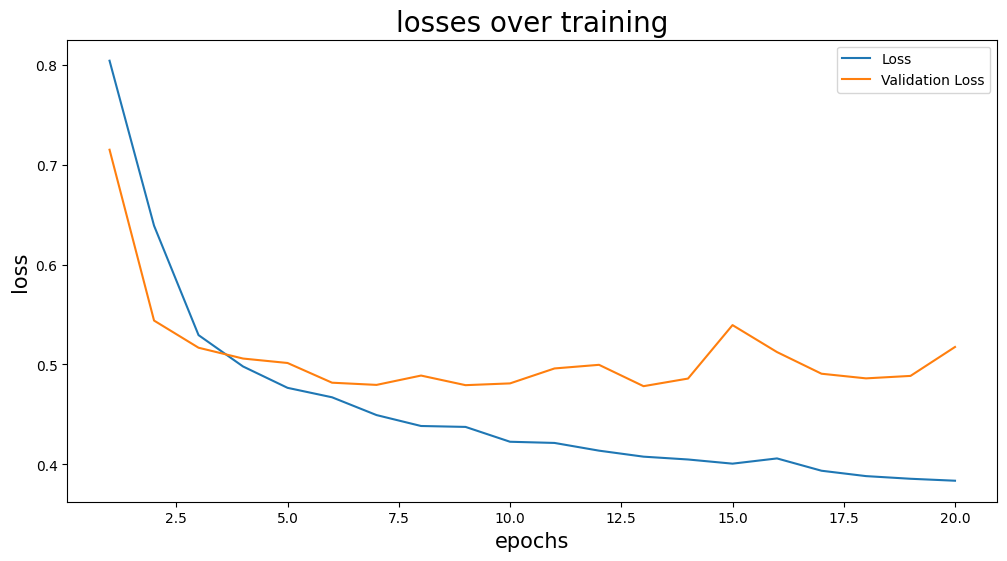

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline
model.load_weights(checkpoint_path)
plt.figure(figsize=(12, 6))
plt.plot(np.arange(20)+1, history.history['loss'], label='Loss')
plt.plot(np.arange(20)+1, history.history['val_loss'], label='Validation Loss')
plt.title('losses over training', fontsize=20)

plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)

plt.legend()
plt.show()

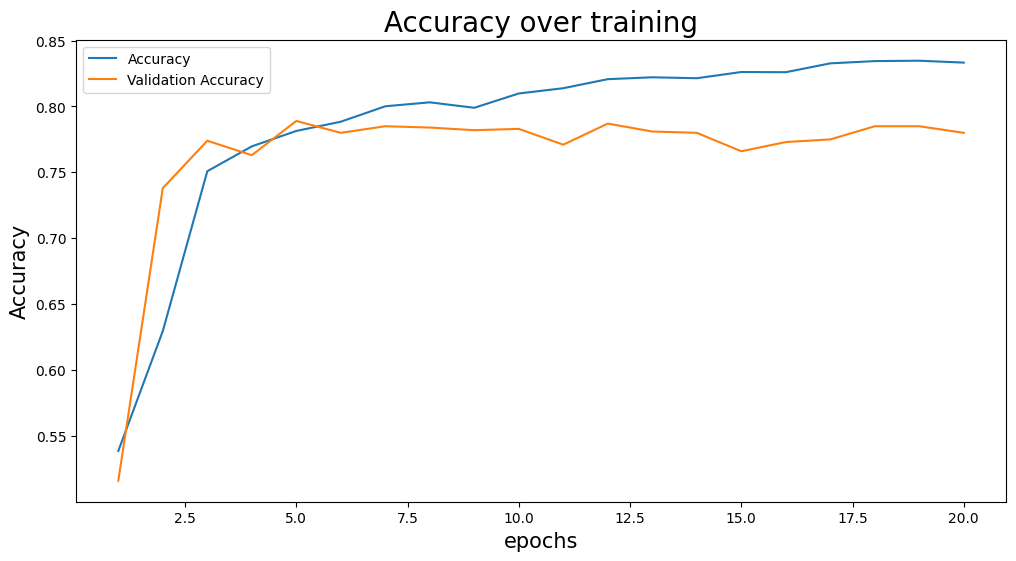

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(20)+1, history.history['accuracy'], label='Accuracy')
plt.plot(np.arange(20)+1, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over training', fontsize=20)

plt.xlabel('epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)

plt.legend()
plt.show()